# Creating sediment input into Landlab NetworkSedimentTransporter component

#### This tutorial was created by graduate students as part of the 2021 CSDMS ESPIn (Earth Surface Processes Institute).

# The NST-notebook
Sediment pulses are synthetically introduced to simulate erosive conditions, which may be caused by fire or landslide occurrences in the landscape, to quantify sediment yield across river network using the **Landlab NetworkSedimentTransporter (NST)** component. 

#### Creators

Se Jong Cho - US Geological Survey

Mel Guirro - Durham University

Muneer Ahammad - Virginia Tech

Marius Huber - CNRS, Université de Lorraine

With help from Shelby Ahrendt - University of Washington

## Notebook Overview
This notebook is the second part of the 'Slope and Channels' group of 2021 CSDMS ESPIn.
The first part used Landlab SPACE component to evaluate how fire or landslide would increase sediment availability from hillslopes into channels.

This second part will synthetically introducte the increased sediment availability from fire or landslide at adjacent nodes and
use the Landlab NetworkSedimentTransporter (NST) component to run the sediment through the river network.


### Modeling Objectives
1. **Demonstrate a potential to couple NST with existing landlab models that generate sediment sources or other sediment input conditions**: We present here the overall modeling framework linking Landlab NetworkSedimentTransport (NST) component to Landlab SPACE component. We imported DEM generated from running SPACE component with random fire generations over the simulation period and converted to stream network.  

2. **Run the NetworkSedimentTransporter with pulses of sediment to understand the impact of landscape disturbance on sediment yield**: We evaluate sediment delivery and yield across a stream network in response to random pulses of sediment synthetically generated in the NST module. 

## Conceptual Model


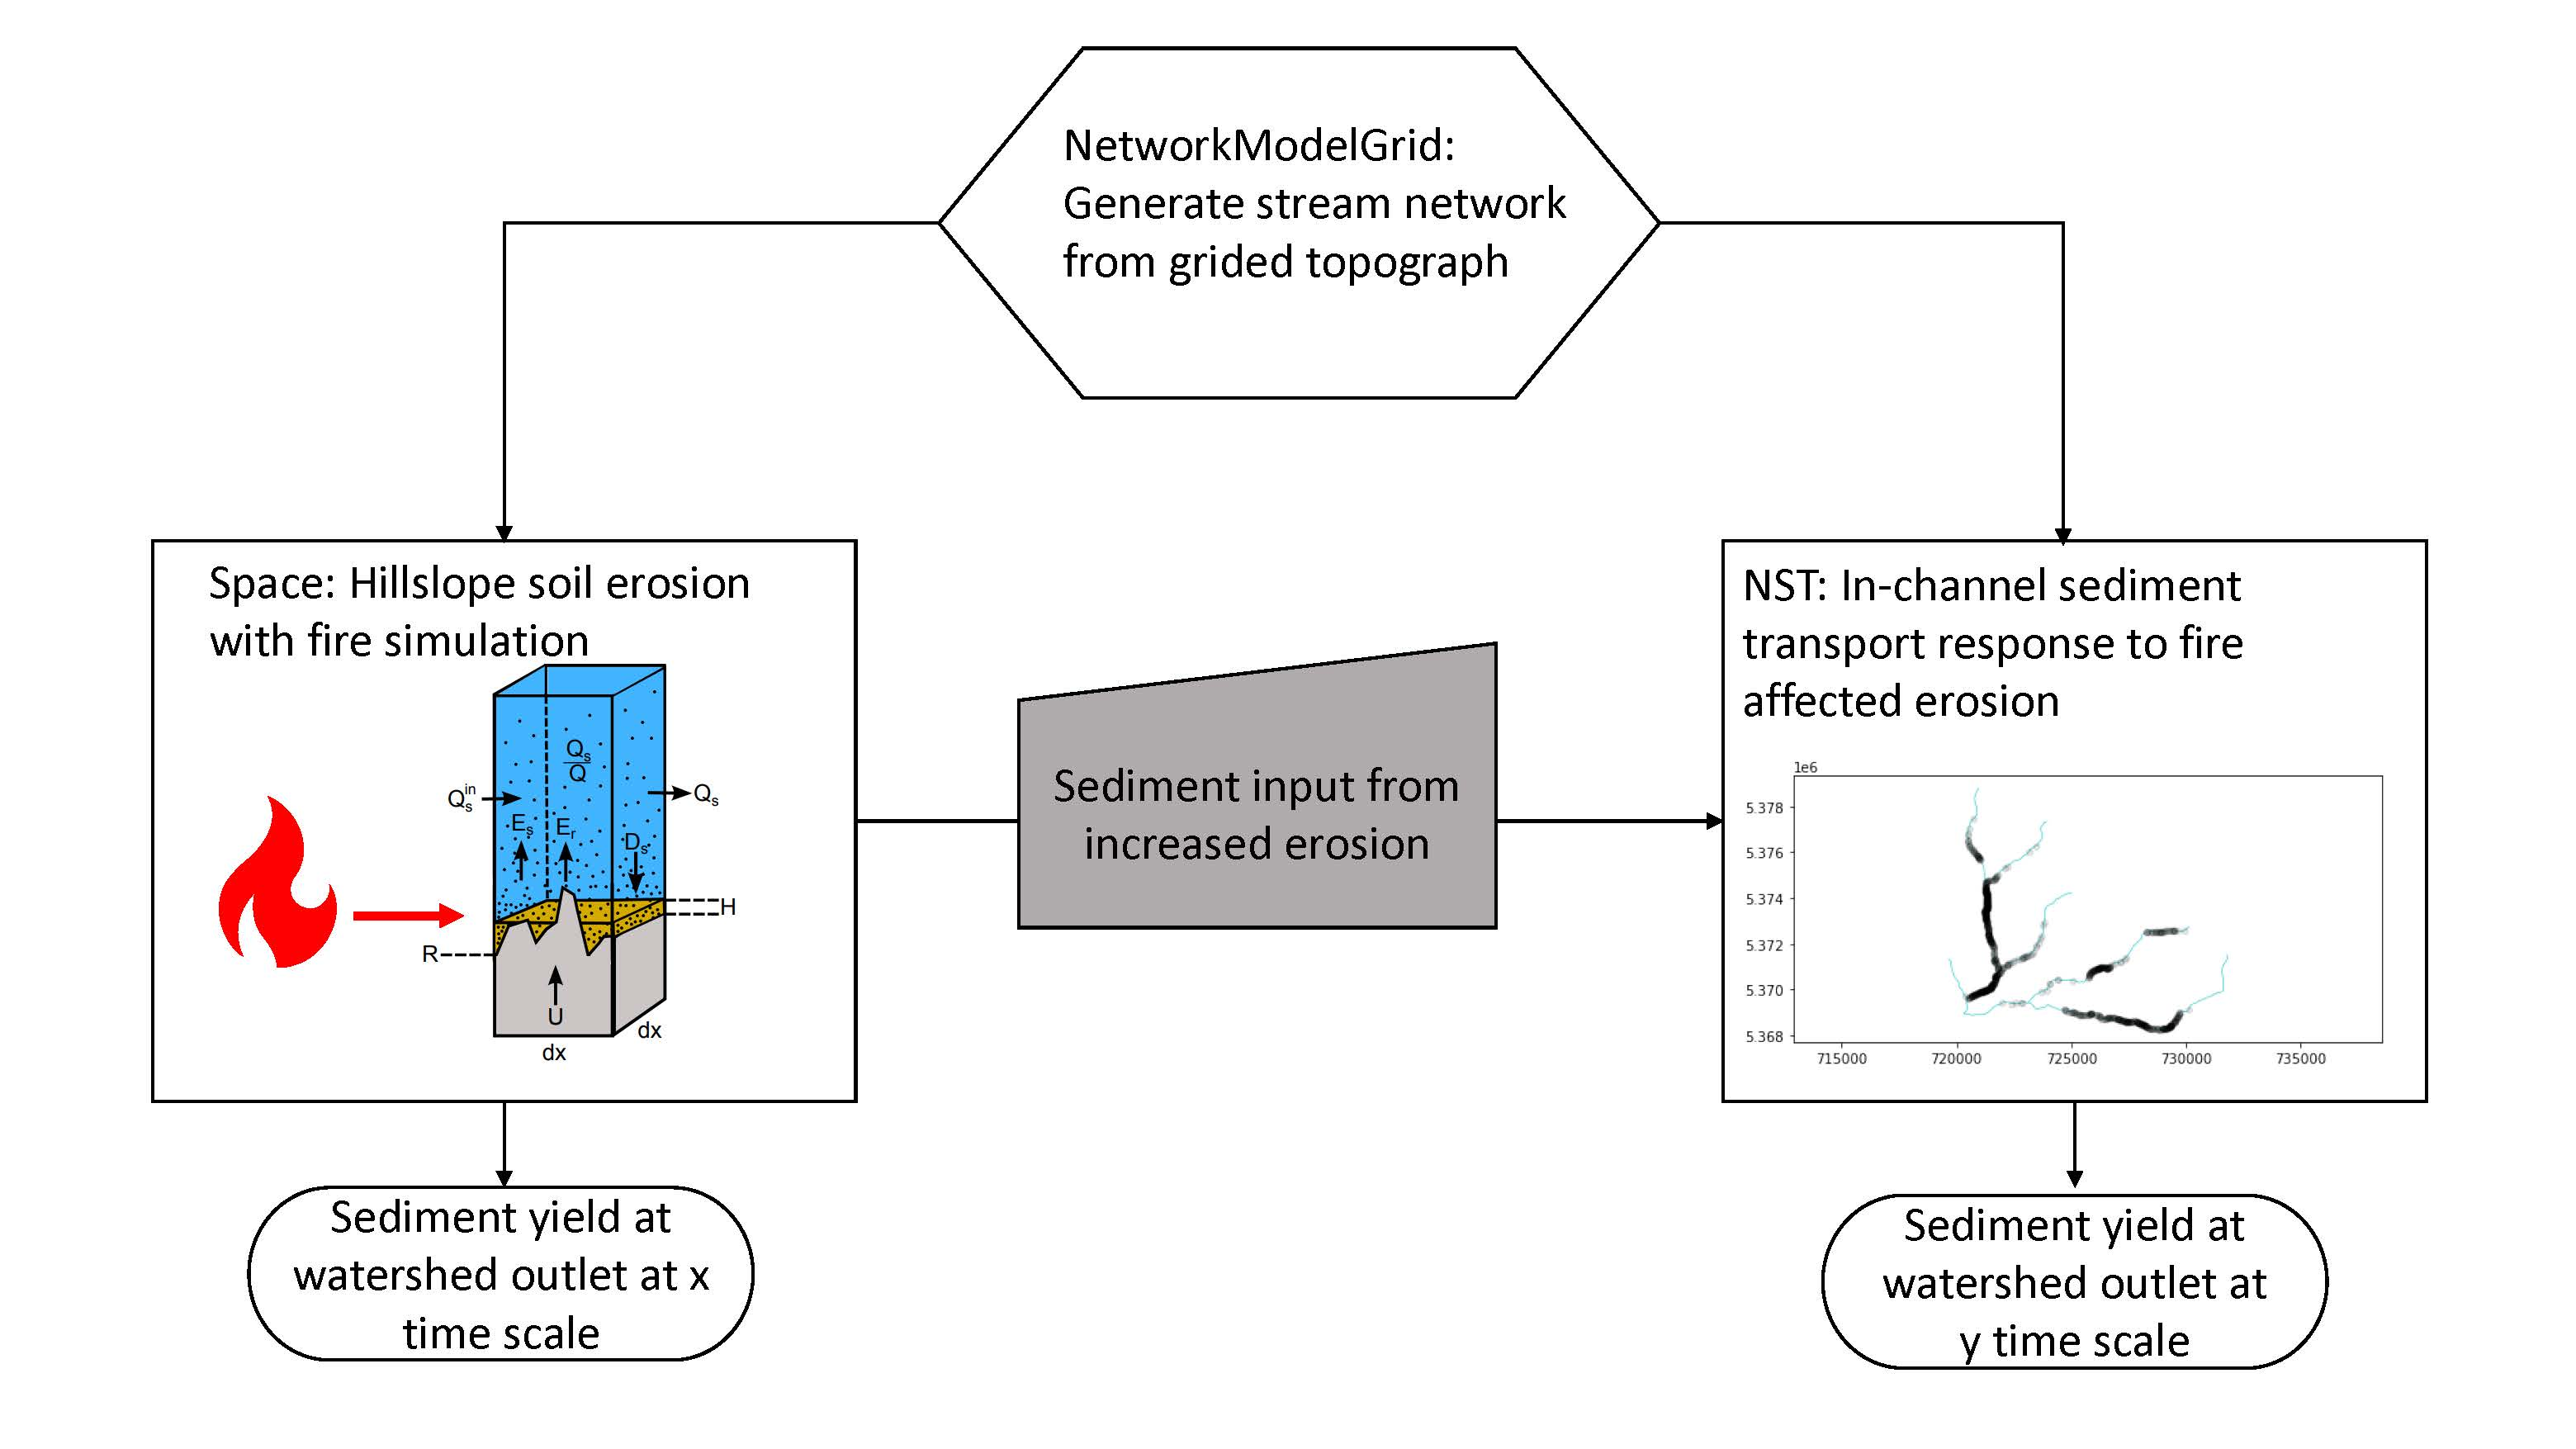

### Landlab Components used
Space

NetworkSedimentTransporter


**Note**: Further work is required to complete the modeling objective 1. Though **Create Network from Raster** successfully generates stream network, the numbers of nodes and links are mismatched. We are currently working to debug the code, which will have a wide utility beyond this project. 

## Load the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import shapefile 

from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node

from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid

from landlab.plot import graph
from landlab.plot import plot_network_and_parcels

from landlab.io import read_esri_ascii

# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

import landlab.plot.colors
from landlab import (RasterModelGrid,
                     imshow_grid)

%matplotlib inline

## 1. Create the river network model grid from landscape grid created from SPACE

Import the Digital Elevation Model (DEM) created from Space simulation and plot it.

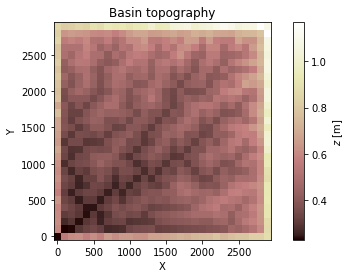

In [2]:
#Fetch DEM ascii

#slopeChannel_dir = os.path.dirname('/home/marius/Documents/Doctorat/ESPIn/slopes-channels/') #NEED TO ENTER CORRECT DIRECTORY!!!
#raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
#raster_fn = os.path.join(slopeChannel_dir, 'exampleDEM.asc') #windows
raster_fn = open('exampleDEM.asc', 'r') #I moved the file from the parent directory to /NST to access this file

#define landcape grid
mg, z = read_esri_ascii(raster_fn, name='exampleDEM')
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] =z
#rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
#rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

##topographic__elevation=z

#plot dem
plt.figure(figsize=(8,4))
imshow_grid(mg, 'exampleDEM',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

## 2. Create a Network Grid from Raster Grid
Extracts a NetworkModelGrid from the imported DEM or RasterModelGrid using the python model 'create_network_from_raster' in create_network.py.

Then plots the nodes, links, and node&link on DEM. This is the stream network/node for running NST.


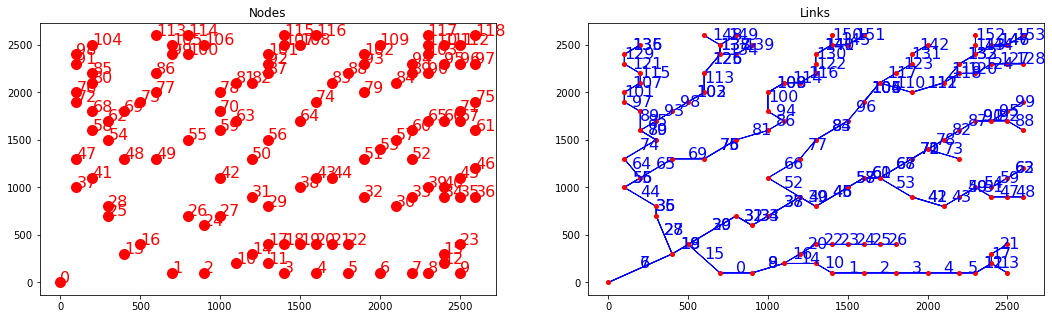

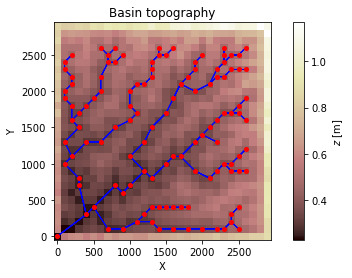

In [3]:
#create channel network grid from landscape grid from <Space team: minimalSpaceExample.ipynb>
from create_network import create_network_from_raster # Shelby's code to make a channel network from a grid

dx = 100 #grid spacing? Is this correct? needs to be checked

nmg = create_network_from_raster(
    mg,
    method='variable', 
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

# Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

# Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

#plot with topo
plt.figure(figsize=(8,4))
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg,with_id=False)
imshow_grid(mg, 'topographic__elevation',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

### Examine the variable outputs from running 'create_network_from_raster'to make sure all the elements are present for running NST.

Let's see what fields we read with new network shapefile we created from DEM output from SPACE

In [ ]:
nmg.number_of_links

In [ ]:
nmg.number_of_nodes

Examine the fields in the nodes:

In [ ]:
nmg.at_node.keys()

In [ ]:
nmg.at_link.keys()

Links are empty because NetworkModelGrid (NMG) created doesn't store information about links. Thus, we need to assign "reach_length", "drainage_area", "x_of_polyline", and "y_of_polyline" in the NMG.

In [ ]:
nmg.add_field("reach_length", nmg.length_of_link, at="link")
nmg.at_link.keys()

In [ ]:
#nmg.add_field("drainage_area", nmg.at_node['drainage_area'], at="link")

In [ ]:
#nmg.add_field("x_of_polyline", nmg.at_node['drainage_area'], at="link")

In [ ]:
#nmg.add_field("y_of_polyline", nmg.at_node['drainage_area'], at="link")

<font color="red"> There are still problems with the network created from DEM ([no. of node] $\not=$ [no. of links]+1), which makes it incompatible with NST.  We are working with the authors of the code to debug **create_network_from_raster** in **create_network.py** </font>. 
    
## From here on we demonstrate NST modified by external sediment sources from fire/landslide using an example shape file

1. Import example shapefile (Methow watershed) from LANDLAB's **ExampleData**.
2. Using **read_shapefile** from LANDLAB library, create a river network grid of **links and nodes**.

Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes.

In [4]:
# we will need to import additional libraries to load and read the example shapefile
from landlab.io import read_shapefile
from landlab import ExampleData

# Import shapefile of Methow Basin
datadir = ExampleData("io/shapefile", case="methow").base

shp_file = datadir / "MethowSubBasin.shp"
points_shapefile = datadir / "MethowSubBasin_Nodes_4.shp"

grid = read_shapefile(
    shp_file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_km2", "Elev_m"],
    link_fields=["usarea_km2", "Length_m"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_km2": "drainage_area",
        "Elev_m": "topographic__elevation",
    },
    threshold=0.01,
    )

Let's take a look at the shape files (**MethowSubBasin.shp** and **thowSubBasin_Nodes_4.shp**)

In [ ]:
from PIL import Image

Methow=Image.open('Methow.jpg')
display(Methow)

Now, check the number of links and nodes (i.e., <font color="red"> [no. of node]=[no. of links]+1 </font>)

Check the fields stored in the links and nodes, imported from the shapefile attributes.

Finally, plot the links and nodes (note that **read_shapefile** assigned new node and link identifiers).

In [ ]:
grid.number_of_links

In [ ]:
grid.number_of_nodes

In [ ]:
grid.at_link.keys()

In [ ]:
grid.at_node.keys()

In [ ]:
graph.plot_graph(grid, at="node,link")

## 3. Set up elements for running NST


Populate the grid with the relevant topographic and hydrologic information necessary for running NST.

1. Topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment) are defined separately. Here we assumed the bedrock elevation is 10% lower than surface elevation, 
2. Channel width is 2 meters 
3. Flow depth is 1 meter.

In [5]:
 #set bedrock elevation given the topographic elevation
grid.at_node["bedrock__elevation"] =0.9* grid.at_node["topographic__elevation"].copy()
#set an arbitary channel width
grid.at_link["channel_width"] = 2 * np.ones(grid.number_of_links) # m
#set an arbitrary flow depth
grid.at_link["flow_depth"] = 1 * np.ones(grid.number_of_links) # m

### Following figure illustrates influences of natural events such as wildfire and landslide on sediment supply and transport through the river system:

In [ ]:
from IPython.display import Image
Image(filename='image.png')

## Create random sediment 'parcels' in a DataRecord

First, let's create arrays with all of the essential sediment parcel variables.
We want to randomly assign parcels in the channel links. We use a normal (Gaussian) distribution.

In [6]:
# Import a statistical function to define a function for truncated normal continuous random variable
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [7]:
# Define the parameters mean, standard deviation, and truncation range
norm_param = get_truncated_normal(mean=100, sd=50, low=0, upp=200) # update these values if I want to change the distribution

In [8]:
# Use the parameters to generage a random normal distribution of number of parcels in links
number_parcels = norm_param.rvs(grid.number_of_links).astype(np.int64) # rvs means random variables

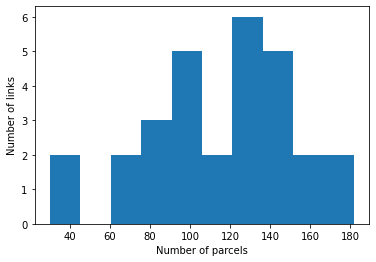

In [9]:
# You can visualize the random distribution
count, bins, ignored = plt.hist(number_parcels, 10)
plt.ylabel('Number of links')
plt.xlabel('Number of parcels')
plt.show()

In [10]:
# Check how many parcels are in each link
print(number_parcels)

[132  81 151 159 126 125  86 145 149 172  99 118 102 128 118 138 182  95
  79 127 132  93  30 153  71  35 150  72 104]


Now, we can assign the random distribution of sediment parcels (i.e., `number_parcels` defined above) to the links (`element_id`) of our grid. Then, define sediment characteristics and grain size distribution.

We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab [DataRecord](../data_record/DataRecord_tutorial.ipynb).

In [11]:
# Assign the parcels for an element_id, wich is the link on which the parcel begins
element_id = np.repeat(np.arange(grid.number_of_links), number_parcels)
element_id = np.expand_dims(element_id, axis=1)

# Sediment characteristics of each parcel
volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Randomly define the grain size of parcel: Lognormal GSD
medianD = 0.15 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which is a normalized value ranging from 0 to 1) according to a sediment transport formula, which is to be defined when NST is executed below (`transport_method="WilcockCrowe"`). 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [12]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. For example:

In [13]:
lithology = ["quartzite"] * np.size(element_id)

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time :

In [14]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels `DataRecord`. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "dummy_element" here, which has index value -2.

In [15]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## 4. Run the NetworkSedimentTransporter

With the parcels and grid set up, we can move on to setting up the model.

In [16]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *2 # length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component:

In [17]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

Then initialize the NST:

In [18]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

Now we are ready to run the model forward in time:

In [19]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    print("Model time: ", t/(60*60*24), "days passed")

Model time:  0.0 days passed
Model time:  2.0 days passed
Model time:  4.0 days passed
Model time:  6.0 days passed
Model time:  8.0 days passed
Model time:  10.0 days passed
Model time:  12.0 days passed
Model time:  14.0 days passed
Model time:  16.0 days passed
Model time:  18.0 days passed


## 5. Plot the model results

There are landlab plotting tools specific to the `NetworkSedimentTransporter`. In particular, `plot_network_and_parcels` creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes.  

Here, we demonstrate one example use of `plot_network_and_parcels`. For a thorough tutorial on the plotting tools, see [this notebook](../network_sediment_transporter/network_plotting_examples.ipynb).


We can color links by values that we calculate. For example, if we are curious about the fate of sediment that started out on link 18, we can plot the total volume of sediment that originated (t=0) on link 18.

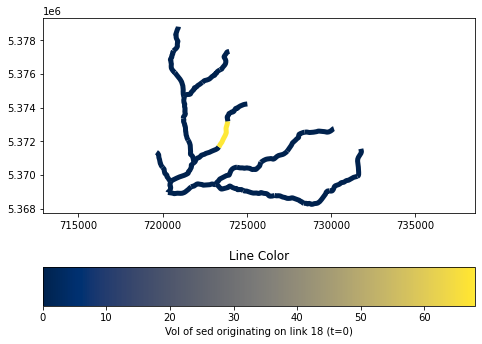

In [20]:
timestep_of_interest = 0
originating_link = 18

#filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(
    parcels.dataset.element_id, dtype=bool
)
parcelfilter[:, timestep_of_interest] = (parcels.dataset.element_id[:,0] == originating_link)

vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

fig18_0 = plot_network_and_parcels(
    grid, parcels,
    link_attribute=vol_orig_link, 
    link_attribute_title = "Vol of sed originating on link 18 (t=0)",
    network_linewidth = 5,
    parcel_alpha = 0
)

Another example, let's look at sediment generated on link 25 at the initial time step. Observe that the sediment volume is tracked from different tributary than the above example. 

If we are curious about the fate of sediment that started out on link 25, we might want to plot the total volume of sediment that originated on link 25 during a later timestep (t=5 and t=10). Observe that volume of sediment has moved downstream in the plots below.

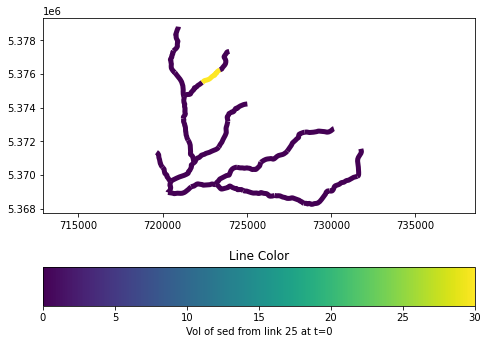

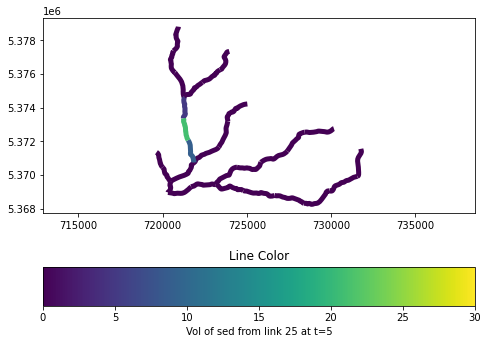

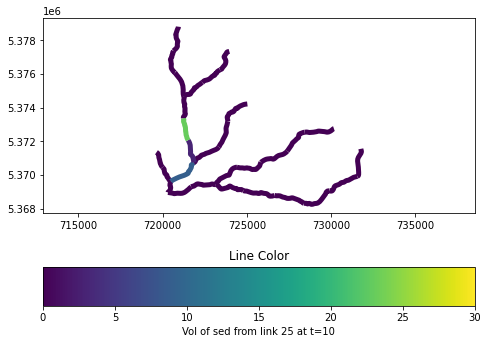

In [58]:
# Setting timesteps and link that we want to analyse
timesteps_of_interest = [0, 5, 10]
originating_link = 25

# Creating empty list to store our figures
figures = []

# set the colourbar and noramlise the colorscale for better visualization
import matplotlib.cm as cm
from matplotlib.colors import Normalize
network_norm = Normalize(0, 30)
network_cmap = cm.viridis

# Create figure for every timestep
for t in timesteps_of_interest:
    
    # filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
    parcelfilter = np.zeros_like(
        parcels.dataset.element_id, dtype=bool
    )
    parcelfilter[:, t] = (parcels.dataset.element_id[:,0] == originating_link)
    
    
    vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

    fig25 = plot_network_and_parcels(
        grid, parcels,
        link_attribute=vol_orig_link, 
        link_attribute_title = f"Vol of sed from link 25 at t={t}",
        network_linewidth = 5,
        network_norm = network_norm,
        network_cmap = network_cmap,
        parcel_alpha = 0
    )
    figurename = f'fig25_timestep_{t}.png'
    figures.append(figurename) # Storing each figure at 'figures' list
    plt.savefig(figurename, bbox_inches='tight')


# Build gif with the generated images
import imageio

with imageio.get_writer('mygif.gif', mode = 'I') as writer:
    for figurename in figures:
        image = imageio.imread(figurename)
        writer.append_data(image)

Now you can check the generated figures and the gif at your main directory!

Below, we demonstrate one example use of plot_network_and_parcels, which creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes. 

Below, each link (represented as a line) is colored by the total volume of sediment on the link. Each parcel is colored by the parcel grain size.

Note that there parcels were randomly assigned to links, so there are links with no parcels and links with many parcels

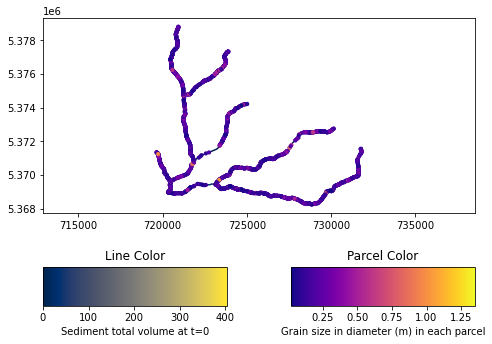

In [24]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    parcel_color_attribute_title="Grain size in diameter (m) in each parcel",
    link_attribute="sediment_total_volume", 
    link_attribute_title = "Sediment total volume at t=0",
    parcel_size=10, 
    parcel_alpha=1.0)

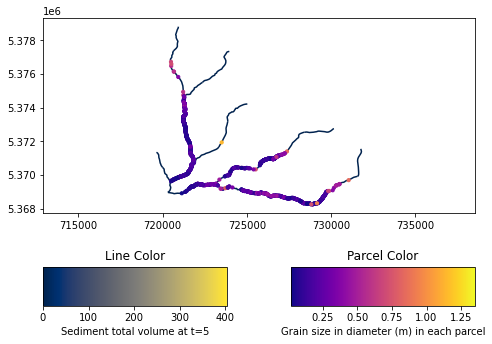

In [25]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=5, 
    parcel_color_attribute="D",
    parcel_color_attribute_title="Grain size in diameter (m) in each parcel",
    link_attribute="sediment_total_volume", 
    link_attribute_title = "Sediment total volume at t=5", 
    parcel_size=10, 
    parcel_alpha=1.0)

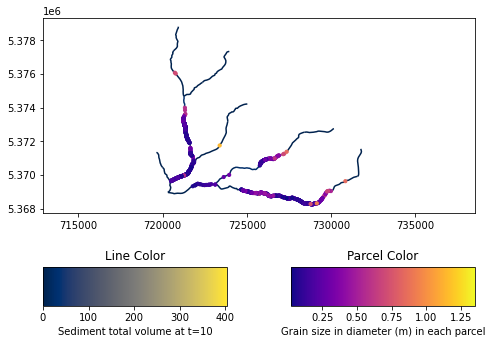

In [26]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=10, 
    parcel_color_attribute="D",
    parcel_color_attribute_title="Grain size in diameter (m) in each parcel",
    link_attribute="sediment_total_volume", 
    link_attribute_title = "Sediment total volume at t=10",
    parcel_size=10, 
    parcel_alpha=1.0)

### Non-network plotting

The results of the NST can be visualized by directly accessing information about the grid, the parcels, and by accessing variables stored after the run of NST.

As a simple example, we can plot the total volume of parcels on the grid through time. As parcels exit the grid, the total volume decreases.

In [ ]:
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         np.sum(parcel_vol_on_grid, axis=0),
         '-',
         linewidth=3, 
         alpha=0.5
        )

plt.ylabel('Total volume of parcels on grid $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 

We can also plot individual parcel characteristics. The plot below shows the total transport distance of each parcel through the whole model run as a function of the parcel's grain size (during the final timestep). 

In [ ]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance (m)')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate

The plot below is an example of accessing variables associated with the grid (grid.at_link.X, or grid.at_node.X), as well as a variable associated with this instance of NetworkModelGrid (nmg.X):

In [ ]:
plt.plot(grid.at_link["channel_slope"],
         nst.d_mean_active, 
         '.')
plt.xlabel('Channel slope (m/m)')
plt.ylabel('Mean grain size of active layer (m)')

## Conclusion & Next Steps
We presented a modeling framework linking multiple LandLab components to understand sediment dynamic in stream network resulting from landscape disturbances, such as randome fires, landslides, or landcover changes. In this example we showed how we might connect NST with SPACE, and with a simple stream network model we demonstrated how variable sediment inputs affect sediment transport throughout the stream network. 

Next steps are:
1) Complete the modeling framework to couple more than one LandLab components (e.g., SPACE, HyLand) by debugging the code to generate stream network grid from DEM. Such a modeling framework provides a foundation for exploring the instantaneous and long-term changes to sediment transport in the stream network. For example, HYLAND may be coupled with NST to examine the impact of landslide on downstream sediment flux. 

2) Develop suspened solid load algorithm to append to the current NST component.




## END